In [6]:
import pandas as pd
import boto3
import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
load_dotenv(dotenv_path='.secrets')
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = os.getenv('AWS_DEFAULT_REGION')
os.environ['MLFLOW_DEFAULT_ARTIFACT_ROOT'] = os.getenv('MLFLOW_DEFAULT_ARTIFACT_ROOT')
os.environ['S3_BUCKET'] = os.getenv('S3_BUCKET')
s3 = boto3.client('s3')

In [11]:
s3.download_file(os.getenv('S3_BUCKET'), 'dataset/fraudTest.csv', 'fraudTest.csv')
df = pd.read_csv("fraudTest.csv", sep=',')

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
df.info(), display(df.head(), df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,555719,5.557190e+05,555719,555719,555719.000000,555719,555719,555719,555719,555719,555719,555719.000000,555719.000000,555719.000000,5.557190e+05,555719,555719,555719,5.557190e+05,555719.000000,555719.000000,555719.000000
unique,NaN,544760,NaN,693,14,NaN,341,471,2,924,849,50,NaN,NaN,NaN,NaN,478,910,555719,NaN,NaN,NaN,NaN
top,NaN,2020-12-19 16:02:22,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,444 Robert Mews,Birmingham,TX,NaN,NaN,NaN,NaN,Film/video editor,1977-03-23,2da90c7d74bd46a0caf3777415b3ebd3,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,1859,56370,NaN,11443,12146,304886,1474,2423,40393,NaN,NaN,NaN,NaN,4119,2408,1,NaN,NaN,NaN,NaN
mean,277859.000000,NaN,4.178387e+17,NaN,NaN,69.392810,NaN,NaN,NaN,NaN,NaN,NaN,48842.628015,38.543253,-90.231325,8.822189e+04,NaN,NaN,NaN,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,NaN,1.309837e+18,NaN,NaN,156.745941,NaN,NaN,NaN,NaN,NaN,NaN,26855.283328,5.061336,13.721780,3.003909e+05,NaN,NaN,NaN,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,NaN,6.041621e+10,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1257.000000,20.027100,-165.672300,2.300000e+01,NaN,NaN,NaN,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,NaN,1.800429e+14,NaN,NaN,9.630000,NaN,NaN,NaN,NaN,NaN,NaN,26292.000000,34.668900,-96.798000,7.410000e+02,NaN,NaN,NaN,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,NaN,3.521417e+15,NaN,NaN,47.290000,NaN,NaN,NaN,NaN,NaN,NaN,48174.000000,39.371600,-87.476900,2.408000e+03,NaN,NaN,NaN,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,NaN,4.635331e+15,NaN,NaN,83.010000,NaN,NaN,NaN,NaN,NaN,NaN,72011.000000,41.894800,-80.175200,1.968500e+04,NaN,NaN,NaN,1.385867e+09,41.954163,-80.264637,0.000000


(None, None)

In [14]:
# suppresion des colonnes inutiles
df.drop(columns=["Unnamed: 0","trans_num","unix_time"], inplace=True)

In [15]:
# traitement des dates
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], format="%Y-%m-%d %H:%M:%S")
df["year"]= df["trans_date_trans_time"].dt.year
df["month"]=df["trans_date_trans_time"].dt.month
df["day"]=df["trans_date_trans_time"].dt.day
df["hour"]=df["trans_date_trans_time"].dt.hour
df["minute"]=df["trans_date_trans_time"].dt.minute
df["second"]=df["trans_date_trans_time"].dt.second

df["dob"] = pd.to_datetime(df["dob"], format="%Y-%m-%d")
df["dob_year"] = df["dob"].dt.year
df["dob_month"] = df["dob"].dt.month
df["dob_day"] = df["dob"].dt.day

df.drop(columns=["dob","trans_date_trans_time"], inplace=True)

In [16]:
# vérification des valeurs manquantes et des types de données
df.isnull().sum(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   cc_num      555719 non-null  int64  
 1   merchant    555719 non-null  object 
 2   category    555719 non-null  object 
 3   amt         555719 non-null  float64
 4   first       555719 non-null  object 
 5   last        555719 non-null  object 
 6   gender      555719 non-null  object 
 7   street      555719 non-null  object 
 8   city        555719 non-null  object 
 9   state       555719 non-null  object 
 10  zip         555719 non-null  int64  
 11  lat         555719 non-null  float64
 12  long        555719 non-null  float64
 13  city_pop    555719 non-null  int64  
 14  job         555719 non-null  object 
 15  merch_lat   555719 non-null  float64
 16  merch_long  555719 non-null  float64
 17  is_fraud    555719 non-null  int64  
 18  year        555719 non-null  int32  
 19  mo

(cc_num        0
 merchant      0
 category      0
 amt           0
 first         0
 last          0
 gender        0
 street        0
 city          0
 state         0
 zip           0
 lat           0
 long          0
 city_pop      0
 job           0
 merch_lat     0
 merch_long    0
 is_fraud      0
 year          0
 month         0
 day           0
 hour          0
 minute        0
 second        0
 dob_year      0
 dob_month     0
 dob_day       0
 dtype: int64,
 None)

In [17]:
# distribution de la variable cible
df["is_fraud"].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [ ]:
# sauvegarde du dataset pré-traité
# df.to_csv("dataset_training.csv", index=False)
# s3 = boto3.client(
#     "s3",
#     aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
#     aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
#     region_name=os.getenv('AWS_DEFAULT_REGION')
# )
# s3.upload_file("dataset_training.csv", os.getenv('S3_BUCKET'), "dataset/dataset_training.csv")

In [18]:
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")  

Training set size: (444575, 26), Test set size: (111144, 26)


In [19]:
# Sélection des features numeriques et categoriques
numeric_features = X.select_dtypes(include=['int64', 'float64', "int32"]).columns
categoric_features = X.select_dtypes(include=['object']).columns
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)])



In [20]:
# modèle de base : Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', lr)])
model.fit(X_train, y_train)

y_pred = model.predict(X_train)


print("F1 score (train):", f1_score(y_train, y_pred))
print("Recall (train):", recall_score(y_train, y_pred))
print("Precision (train):", precision_score(y_train, y_pred))


F1 score (train): 0.10793131643499591
Recall (train): 1.0
Precision (train): 0.05704407951598963


F1 score (test): 0.09323195812040384
Recall (test): 0.8717948717948718
Precision (test): 0.049249407426915984
confusion_matrix (test [[103495   7220]
 [    55    374]]


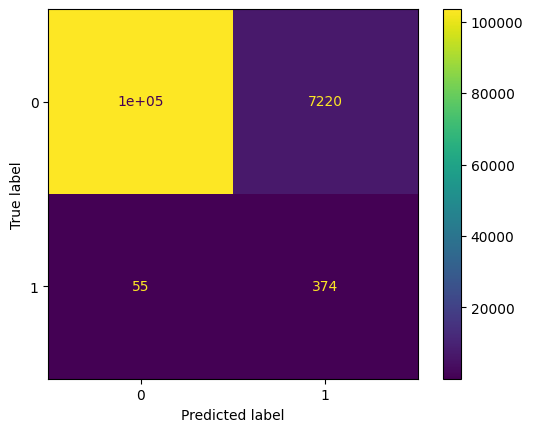

In [23]:
# Évaluation sur le jeu de test
y_pred_test = model.predict(X_test)

print("F1 score (test):", f1_score(y_test, y_pred_test))
print("Recall (test):", recall_score(y_test, y_pred_test))
print("Precision (test):", precision_score(y_test, y_pred_test))
print("confusion_matrix (test", confusion_matrix(y_test, y_pred_test))
_ = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)




Le modèle de régression logistique performe très mal sur la détection de fraude, ce qui le rend inutilisable en production.

Bien que le Recall soit élevé (0.87) — ce qui signifie que le modèle parvient à récupérer une bonne partie des fraudes existantes — les autres indicateurs révèlent une forte instabilité :

Precision extrêmement faible (0.05) :
Le modèle déclenche près de 95 % de fausses alertes, ce qui générerait un très grand nombre de transactions bloquées à tort.

F1-score très bas (0.09) :
Ce score global montre que le modèle n’équilibre pas correctement Recall et Precision, confirmant qu’il identifie mal les fraudes réelles.

Il n'est donc pas adapté à un cas d’usage réel, où la priorité est un compromis entre Recall et Precision pour éviter une interruption excessive du service.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=1000; total time= 1.5min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=1000; total time= 1.6min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=1000; total time= 1.7min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=1200; total time= 1.7min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=1000; total time= 1.8min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=1000; total time= 1.9min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=1200; total time= 1.9min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=1500; total time= 2.1min
[CV] END regressor__learning_rate=0.1, reg

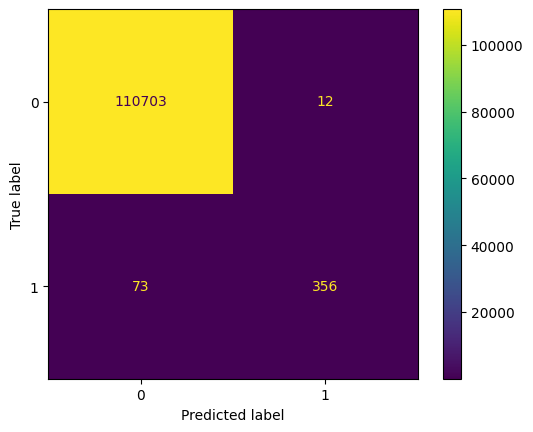

In [24]:
# Modèle XGBoost avec GridSearchCV
xgb = XGBClassifier()
model_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb)])


param_grid={
    'regressor__n_estimators': [1000, 1200, 1500],
    'regressor__max_depth': [5, 10, 15],
    'regressor__learning_rate': [0.1, 0.2, 0.3]
    }

grid_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train, y_train)
print("Best parameters found: ", grid_xgb.best_params_)
best_model = grid_xgb.best_estimator_
y_pred_best = best_model.predict(X_test)

print("F1 score (test):", f1_score(y_test, y_pred_best))
print("Recall (test):", recall_score(y_test, y_pred_best))
print("Precision (test):", precision_score(y_test, y_pred_best))
print("confusion_matrix (test", confusion_matrix(y_test, y_pred_best))
_ = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

Ce modèle obtient de très bonnes performances. 

Le F1_score de 0.89 montre un très bon équilibre entre précision et recall.

Une précision de 0.96 signifie que le modèle se trompe rarement quand  il dit "fraude". Limite donc les fausses alertes et donc le blocage de transactions légitimes.

Le recall de 0.83 montre que le modèle capture 83 % des fraudes réelles. C'est bien mais il reste un petit nombre de fraudes non détectées.

Ce modèle est nettement meilleur que la regression logistique et semble convenir à une mise en production.

In [ ]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
model_rf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', rf)])



Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  48.5s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  54.0s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  57.2s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  50.5s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  50.0s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=200; total time= 1.8min
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=200; total time= 1.9min
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=200; total time= 1.8min
[CV] END regressor__max_de

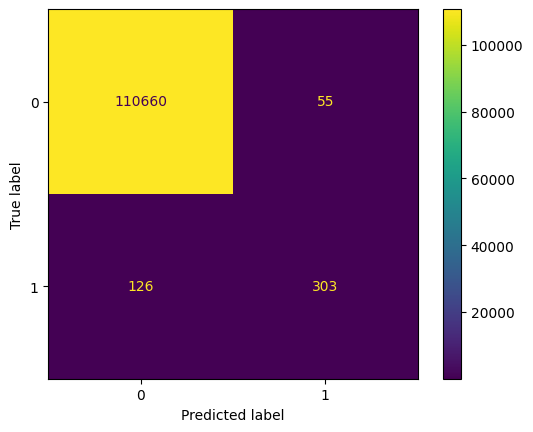

In [ ]:
param_grid_rf={
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [30, 50, 70],
    'regressor__min_samples_split': [2, 5, 8]
    }
grid_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=1,
    verbose=2
)
grid_rf.fit(X_train, y_train)
print("Best parameters found: ", grid_rf.best_params_)
best_model_rf = grid_rf.best_estimator_
y_pred_best_rf = best_model_rf.predict(X_test)

print("F1 score (test):", f1_score(y_test, y_pred_best_rf))
print("Recall (test):", recall_score(y_test, y_pred_best_rf))
print("Precision (test):", precision_score(y_test, y_pred_best_rf))
print("confusion_matrix (test", confusion_matrix(y_test, y_pred_best_rf))
_ = ConfusionMatrixDisplay.from_estimator(best_model_rf, X_test, y_test)



Le modèle Random Forest présente des performances solides mais inférieures à celles de XGBoost 

Le F1-score de 0.77 est correct, il montre un compromis global satisfaisant entre précision et rappel mais moins performant que le XGBoost


La précision de 0.85 montre que le modeèle est fiable, 85% des alertes sont bien des vraies fraudes, peu de faux positifs

Le recall de 0.70 est coorecte mais il y a beaucoup trop de fraudes qui passent à travers.

Random Forest est un modèle correct, mais moins performant que XGBoost, surtout en termes de détection des fraudes réelles.

### Parmi les modèles testés, XGBoost se distingue nettement grâce à son équilibre idéal entre précision, recall et F1-score.

### Il détecte la majorité des fraudes tout en générant très peu de faux positifs, ce qui en fait le modèle le plus fiable et le plus adapté à une mise en production pour prévenir efficacement la fraude sans perturber les transactions légitimes.